# [G2Net] 1D ResNet


## Reference
- pipeline: [Y.Nakama's notebook](https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-training).
- dataset: @hidehisaarai1213 https://www.kaggle.com/hidehisaarai1213/g2net-read-from-tfrecord-train-with-pytorch
- 1d CNN modified from https://www.kaggle.com/kit716/grav-wave-detection
- Modified from https://www.kaggle.com/scaomath/g2net-1d-cnn-gem-pool-pytorch-train-inference/

## Libraries

In [1]:
import os
import time
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import tensorflow as tf  # for reading TFRecord Dataset
import tensorflow_datasets as tfds  # for making tf.data.Dataset to return numpy arrays
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from kaggle_datasets import KaggleDatasets
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm import tqdm

import sys
sys.path.append('../')
from file_path import *

In [2]:
SAVEDIR = Path(runs_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## CFG

In [3]:
class CFG:
    debug = False
    print_freq = 2500
    num_workers = 4
    scheduler = "CosineAnnealingLR"
#     scheduler = 'ReduceLROnPlateau'
    model_name = "1dresnet"
    epochs = 8
    T_max = 5
    lr = 1e-4
    min_lr = 1e-7
    batch_size = 128
    val_batch_size = 100
    weight_decay = 1e-5
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    factor = 0.2
    patience = 1
    eps = 1e-7
    seed = 1127802826
    target_size = 1
    target_col = "target"
    n_fold = 5
    trn_fold = [1, 3, 4]  # [0, 1, 2, 3, 4]
    train = True
    bandpass_params = dict(lf=25, 
                           hf=500)

## Utils

In [4]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def init_logger(log_file=SAVEDIR / 'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## TFRecord Loader

In [5]:
#gcs_paths = []
#for i, j in [(0, 4), (5, 9), (10, 14), (15, 19)]:
#    path = f"g2net-waveform-tfrecords-train-{i}-{j}"
#    n_trial = 0
#    while True:
#        try:
#            gcs_path = KaggleDatasets().get_gcs_path(path)
#            gcs_paths.append(gcs_path)
#            print(gcs_path)
#            break
#        except:
#            if n_trial > 10:
#                break
#            n_trial += 1
#            continue
#            
#all_files = []
#for path in gcs_paths:
#    all_files.extend(np.sort(np.array(tf.io.gfile.glob(path + "/train*.tfrecords"))))
#    
#print("train_files: ", len(all_files))
#all_files = np.array(all_files)

In [6]:
def count_data_items(fileids, train=True):
    """
    Count the number of samples.
    Each of the TFRecord datasets is designed to contain 28000 samples for train
    22500 for test.
    """
    sizes = 28000 if train else 22600
    return len(fileids) * sizes


AUTO = tf.data.experimental.AUTOTUNE

## Bandpass

Modified from various notebooks and https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/261721#1458564

In [7]:
def bandpass(x, lf=20, hf=500, order=8, sr=2048):
    '''
    Cell 33 of https://www.gw-openscience.org/LVT151012data/LOSC_Event_tutorial_LVT151012.html
    https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
    '''
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    window = signal.tukey(4096, 0.15) # 2s in 4096
    if x.ndim ==1: # one detector
        x *= window
        x = signal.sosfilt(sos, x) * normalization
    if x.ndim ==2: # three detectors
        x *= window
        for i in range(3):
            x[i] = signal.sosfilt(sos, x[i]) * normalization
    elif x.ndim == 3: # batch and three detectors
        for i in range(x.shape[0]):
            x[i] *= window
            for j in range(3):
                x[i, j] = signal.sosfilt(sos, x[i, j]) * normalization
    return x

In [8]:
def prepare_wave(wave):
    wave = tf.reshape(tf.io.decode_raw(wave, tf.float64), (3, 4096))
    normalized_waves = []
    scaling = tf.constant([1.5e-20, 1.5e-20, 0.5e-20], dtype=tf.float64)
    for i in range(3):
#         normalized_wave = wave[i] / tf.math.reduce_max(wave[i])
        normalized_wave = wave[i] / scaling[i]
        normalized_waves.append(normalized_wave)
    wave = tf.stack(normalized_waves, axis=0)
    wave = tf.cast(wave, tf.float32)
    return wave


def read_labeled_tfrecord(example):
    tfrec_format = {
        "wave": tf.io.FixedLenFeature([], tf.string),
        "wave_id": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_wave(example["wave"]), tf.reshape(tf.cast(example["target"], tf.float32), [1]), example["wave_id"]


def read_unlabeled_tfrecord(example, return_image_id):
    tfrec_format = {
        "wave": tf.io.FixedLenFeature([], tf.string),
        "wave_id": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_wave(example["wave"]), example["wave_id"] if return_image_id else 0


def get_dataset(files, batch_size=16, repeat=False, cache=False, 
                shuffle=False, labeled=True, return_image_ids=True):
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO, compression_type="GZIP")
    if cache:
        # You'll need around 15GB RAM if you'd like to cache val dataset, and 50~60GB RAM for train dataset.
        ds = ds.cache()

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(1024 * 2)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    if labeled:
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_ids), num_parallel_calls=AUTO)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTO)
    return tfds.as_numpy(ds)

In [9]:
all_files = np.array([os.path.join(data_path+'tfrecords/train/', f) for f in os.listdir(data_path+'tfrecords/train/') if f.endswith('.tfrecords')])

In [10]:
class TFRecordDataLoader:
    def __init__(self, files, batch_size=32, cache=False, train=True, 
                              repeat=False, shuffle=False, labeled=True, 
                              return_image_ids=True):
        self.ds = get_dataset(
            files, 
            batch_size=batch_size,
            cache=cache,
            repeat=repeat,
            shuffle=shuffle,
            labeled=labeled,
            return_image_ids=return_image_ids)
        
        self.num_examples = count_data_items(files, labeled)

        self.batch_size = batch_size
        self.labeled = labeled
        self.return_image_ids = return_image_ids
        self._iterator = None
    
    def __iter__(self):
        if self._iterator is None:
            self._iterator = iter(self.ds)
        else:
            self._reset()
        return self._iterator

    def _reset(self):
        self._iterator = iter(self.ds)

    def __next__(self):
        batch = next(self._iterator)
        return batch

    def __len__(self):
        n_batches = self.num_examples // self.batch_size
        if self.num_examples % self.batch_size == 0:
            return n_batches
        else:
            return n_batches + 1

In [17]:
ds = tf.data.TFRecordDataset(all_files, num_parallel_reads=AUTO, compression_type="GZIP")
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = tfds.as_numpy(ds)

In [21]:
x = next(iter(ds))

Text(0, 0.5, 'Amplitude')

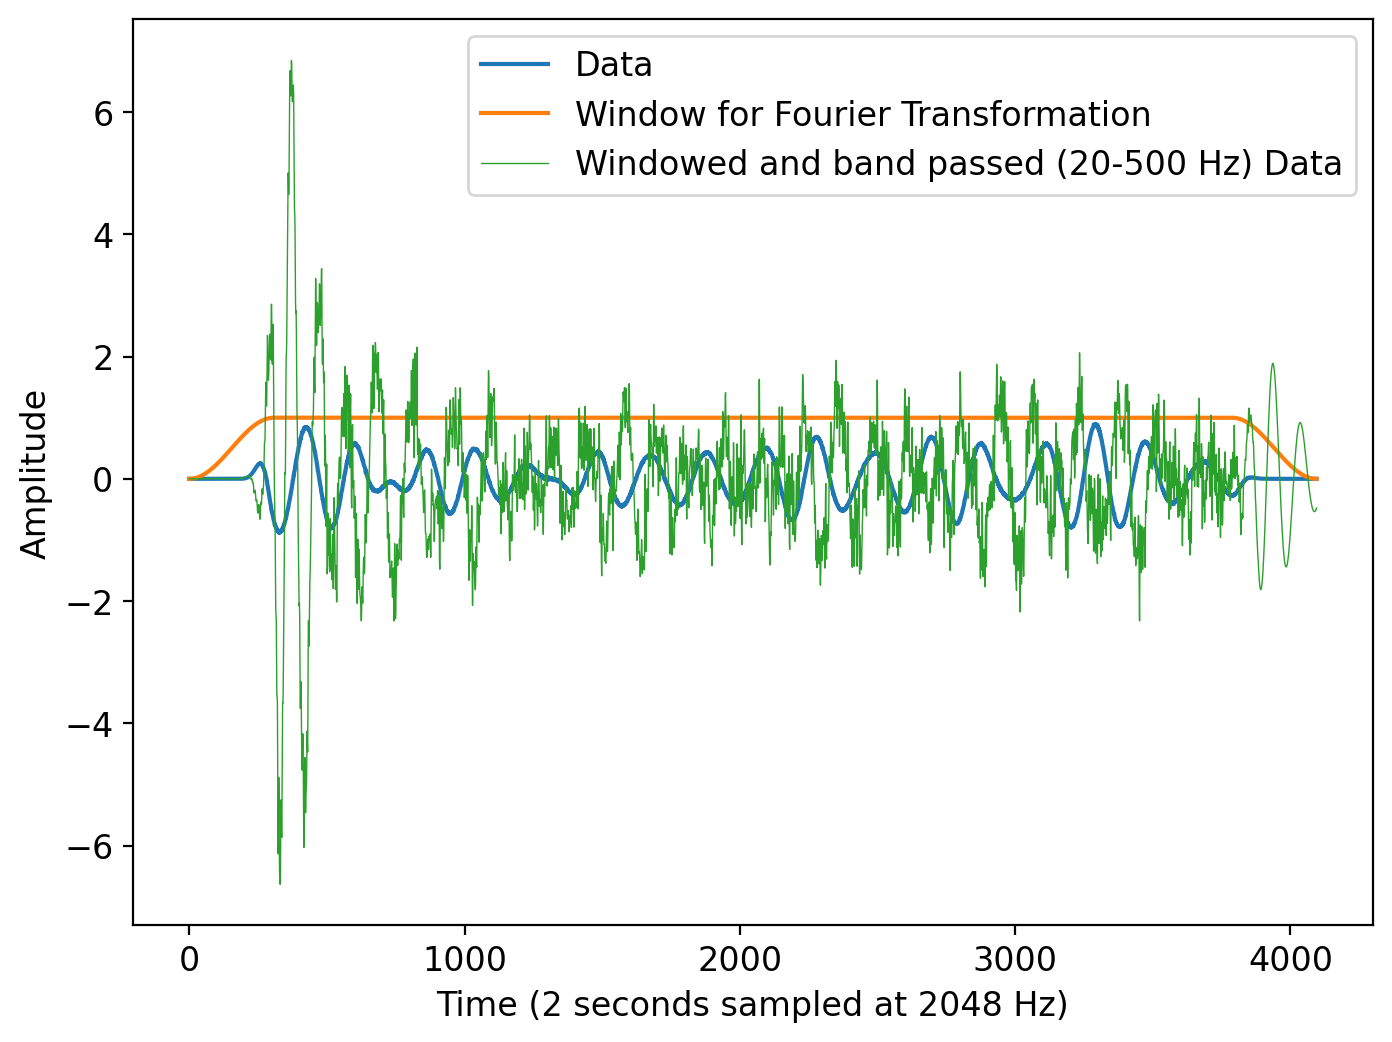

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

#from scipy.signal import butter, lfilter
#
#def butter_bandpass(lowcut, highcut, fs, order=5):
#    nyq = 0.5 * fs
#    low = lowcut / nyq
#    high = highcut / nyq
#    b, a = butter(order, [low, high], btype='bandpass')
#    return b, a
#
#
#def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#    y = lfilter(b, a, data)
#    return y

plt.plot(x[0][1], label='Data')
window = signal.tukey(4096, 0.15)
plt.plot(window, label='Window for Fourier Transformation')
normalization = np.sqrt((500 - 20) / (2048 / 2))
normalization = 1
#plt.plot(butter_bandpass_filter(x[0][1]*window, 50, 500, fs=2048)*normalization)
plt.plot(bandpass(x[0][1], 20, 500)*100, linewidth=0.5, label='Windowed and band passed (20-500 Hz) Data')
plt.legend()
plt.xlabel('Time (2 seconds sampled at 2048 Hz)')
plt.ylabel('Amplitude')

## MODEL

In [11]:
class GeM(nn.Module):
    '''
    Code modified from the 2d code in
    https://amaarora.github.io/2020/08/30/gempool.html
    '''
    def __init__(self, kernel_size=8, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.kernel_size = kernel_size
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool1d(x.clamp(min=eps).pow(p), self.kernel_size).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [12]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=32, padding=16, stride=stride)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=128, padding=63, stride=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        #self.fc = nn.Linear(in_features, out_features, bias=True)
        
    def forward(self, x):
        y1 = F.relu(self.bn1(self.conv1(x)))
        y2 = self.bn2(self.conv2(y1))
        if self.conv3:
            x = self.conv3(x)
        return F.relu(y2+x)
    
    
def resnet_block(in_channels, out_channels, num_residuals, stride=1):
    blk = []
    for i in range(num_residuals):
        if i==0:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=stride))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

In [13]:
def resnet():
    net = nn.Sequential()
    net.add_module('resnet_block_1', resnet_block(in_channels=3, out_channels=32, num_residuals=2, stride=1))
    net.add_module('resnet_block_2', resnet_block(in_channels=32, out_channels=64, num_residuals=1, stride=2))
    net.add_module('resnet_block_3', resnet_block(in_channels=64, out_channels=32, num_residuals=1, stride=2))
    net.add_module('resnet_block_4', resnet_block(in_channels=32, out_channels=16, num_residuals=1, stride=2))
    net.add_module('flatten', nn.Flatten())
    net.add_module('fc1', nn.Linear(in_features=8192, out_features=800, bias=True))
    net.add_module('fc2', nn.Linear(in_features=800, out_features=80, bias=True))
    net.add_module('fc3', nn.Linear(in_features=80, out_features=1, bias=True))
    return net

In [14]:
model = resnet()
#x = torch.rand(5,3,4096)
#model(x)

In [15]:
model

Sequential(
  (resnet_block_1): Sequential(
    (0): Residual(
      (conv1): Conv1d(3, 32, kernel_size=(32,), stride=(1,), padding=(16,))
      (conv2): Conv1d(32, 32, kernel_size=(128,), stride=(1,), padding=(63,))
      (conv3): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv1d(32, 32, kernel_size=(32,), stride=(1,), padding=(16,))
      (conv2): Conv1d(32, 32, kernel_size=(128,), stride=(1,), padding=(63,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block_2): Sequential(
    (0): Residual(
      (conv1): Conv1d(32, 64, kernel_size=(32,), stride=(2,), padding=(16,))
      (conv2): Conv1d(64, 64, ker

## Helper functions

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def max_memory_allocated():
    MB = 1024.0 * 1024.0
    mem = torch.cuda.max_memory_allocated() / MB
    return f"{mem:.0f} MB"

## Trainer

In [21]:
train_loader = TFRecordDataLoader(
        all_files, batch_size=CFG.batch_size, 
        cache=True, shuffle=True)

In [22]:
def train_fn(files, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0

    train_loader = TFRecordDataLoader(
        files, batch_size=CFG.batch_size, 
        shuffle=True)
    for step, d in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        x = bandpass(d[0], **CFG.bandpass_params)
        x = torch.from_numpy(x).to(device)
        labels = torch.from_numpy(d[1]).to(device)

        batch_size = labels.size(0)
        y_preds = model(x)
        loss = criterion(y_preds.view(-1), labels.view(-1))
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0:
            print('Epoch: [{0}/{1}][{2}/{3}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  'Elapsed: {remain:s} '
                  'Max mem: {mem:s}'
                  .format(
                   epoch+1, CFG.epochs, step, len(train_loader),
                   loss=losses,
                   grad_norm=grad_norm,
                   lr=scheduler.get_last_lr()[0],
                   remain=timeSince(start, float(step + 1) / len(train_loader)),
                   mem=max_memory_allocated()))
    return losses.avg


def valid_fn(files, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    filenames = []
    targets = []
    preds = []
    start = end = time.time()
    valid_loader = TFRecordDataLoader(
        files, batch_size=CFG.batch_size * 2, shuffle=False)
    for step, d in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        targets.extend(d[1].reshape(-1).tolist())
        filenames.extend([f.decode("UTF-8") for f in d[2]])
        x = bandpass(d[0], **CFG.bandpass_params)
        x = torch.from_numpy(x).to(device)
        labels = torch.from_numpy(d[1]).to(device)

        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(x)
        loss = criterion(y_preds.view(-1), labels.view(-1))
        losses.update(loss.item(), batch_size)

        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0:
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds).reshape(-1)
    return losses.avg, predictions, np.array(targets), np.array(filenames)

## Train loop

In [23]:
# ====================================================
# Train loop
# ====================================================
def train_loop(train_tfrecords: np.ndarray, val_tfrecords: np.ndarray, fold: int, is_continue = False):
    
    LOGGER.info(f"========== fold: {fold} training ==========")
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                             mode='max', 
                                                             factor=CFG.factor, 
                                                             patience=CFG.patience, 
                                                             verbose=True, 
                                                             eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                             T_max=CFG.T_max, 
                                                             eta_min=CFG.min_lr, 
                                                             last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                       T_0=CFG.T_0, 
                                                                       T_mult=1, 
                                                                       eta_min=CFG.min_lr, 
                                                                       last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    if not is_continue:
        model = resnet()
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
        scheduler = get_scheduler(optimizer)
        
        criterion = nn.BCEWithLogitsLoss()

        best_score = 0.
        best_loss = np.inf

    # ====================================================
    # loop
    # ====================================================
    
    for epoch in range(CFG.epochs):
        print("\n\n")
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_tfrecords, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds, targets, files = valid_fn(val_tfrecords, model, criterion, device)
        valid_result_df = pd.DataFrame({"target": targets, "preds": preds, "id": files})
        
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, optim.lr_scheduler.CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(targets, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        SAVEDIR / f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        SAVEDIR / f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_result_df["preds"] = torch.load(SAVEDIR / f"{CFG.model_name}_fold{fold}_best_loss.pth",
                                          map_location="cpu")["preds"]

    return valid_result_df

In [ ]:
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}')

if CFG.train:
    # train 
    oof_df = pd.DataFrame()
    kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

    folds = list(kf.split(all_files))
    for fold in range(CFG.n_fold):
        if fold in CFG.trn_fold:
            trn_idx, val_idx = folds[fold]
            train_files = all_files[trn_idx]
            valid_files = all_files[val_idx]
            _oof_df = train_loop(train_files, valid_files, fold, is_continue = False)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    # save result
    oof_df.to_csv(SAVEDIR / 'oof_df.csv', index=False)

========== fold: 1 training ==========





Epoch: [1/8][0/3500] Loss: 0.7003(0.7003) Grad: 4.5893  LR: 0.000100  Elapsed: 0m 0s (remain 43m 25s) Max mem: 0 MB
Epoch: [1/8][2500/3500] Loss: 0.4393(0.4671) Grad: 1.6506  LR: 0.000100  Elapsed: 17m 53s (remain 7m 8s) Max mem: 0 MB
EVAL: [0/438] Data 0.148 (0.148) Elapsed 0m 0s (remain 3m 31s) Loss: 0.4300(0.4300) 


Epoch 1 - avg_train_loss: 0.4581  avg_val_loss: 0.4439  time: 1648s
Epoch 1 - Score: 0.8589
Epoch 1 - Save Best Score: 0.8589 Model
Epoch 1 - Save Best Loss: 0.4439 Model





Epoch: [2/8][0/3500] Loss: 0.3680(0.3680) Grad: 1.0486  LR: 0.000090  Elapsed: 0m 0s (remain 37m 44s) Max mem: 0 MB
Epoch: [2/8][2500/3500] Loss: 0.3737(0.4267) Grad: 1.0057  LR: 0.000090  Elapsed: 17m 54s (remain 7m 9s) Max mem: 0 MB
EVAL: [0/438] Data 0.141 (0.141) Elapsed 0m 0s (remain 3m 25s) Loss: 0.4123(0.4123) 


Epoch 2 - avg_train_loss: 0.4250  avg_val_loss: 0.4219  time: 1644s
Epoch 2 - Score: 0.8647
Epoch 2 - Save Best Score: 0.8647 Model
Epoch 2 - Save Best Loss: 0.4219 Model





Epoch: [3/8][0/3500] Loss: 0.4690(0.4690) Grad: 1.4214  LR: 0.000065  Elapsed: 0m 0s (remain 38m 44s) Max mem: 0 MB
Epoch: [3/8][2500/3500] Loss: 0.3465(0.4143) Grad: 0.8734  LR: 0.000065  Elapsed: 17m 48s (remain 7m 6s) Max mem: 0 MB
EVAL: [0/438] Data 0.130 (0.130) Elapsed 0m 0s (remain 3m 18s) Loss: 0.4079(0.4079) 


Epoch 3 - avg_train_loss: 0.4131  avg_val_loss: 0.4169  time: 1637s
Epoch 3 - Score: 0.8673
Epoch 3 - Save Best Score: 0.8673 Model
Epoch 3 - Save Best Loss: 0.4169 Model





Epoch: [4/8][0/3500] Loss: 0.4649(0.4649) Grad: 1.3201  LR: 0.000035  Elapsed: 0m 0s (remain 38m 25s) Max mem: 0 MB
Epoch: [4/8][2500/3500] Loss: 0.4199(0.4039) Grad: 1.5210  LR: 0.000035  Elapsed: 17m 49s (remain 7m 7s) Max mem: 0 MB
EVAL: [0/438] Data 0.150 (0.150) Elapsed 0m 0s (remain 3m 32s) Loss: 0.4066(0.4066) 


Epoch 4 - avg_train_loss: 0.4020  avg_val_loss: 0.4179  time: 1640s
Epoch 4 - Score: 0.8674
Epoch 4 - Save Best Score: 0.8674 Model





Epoch: [5/8][0/3500] Loss: 0.4594(0.4594) Grad: 1.5928  LR: 0.000010  Elapsed: 0m 0s (remain 38m 32s) Max mem: 0 MB
Epoch: [5/8][2500/3500] Loss: 0.3503(0.3959) Grad: 1.2714  LR: 0.000010  Elapsed: 17m 49s (remain 7m 7s) Max mem: 0 MB
EVAL: [0/438] Data 0.142 (0.142) Elapsed 0m 0s (remain 3m 26s) Loss: 0.4083(0.4083) 


Epoch 5 - avg_train_loss: 0.3928  avg_val_loss: 0.4160  time: 1640s
Epoch 5 - Score: 0.8676
Epoch 5 - Save Best Score: 0.8676 Model
Epoch 5 - Save Best Loss: 0.4160 Model





Epoch: [6/8][0/3500] Loss: 0.3255(0.3255) Grad: 1.2334  LR: 0.000000  Elapsed: 0m 0s (remain 39m 9s) Max mem: 0 MB
Epoch: [6/8][2500/3500] Loss: 0.3877(0.3935) Grad: 1.8349  LR: 0.000000  Elapsed: 17m 56s (remain 7m 10s) Max mem: 0 MB
EVAL: [0/438] Data 0.147 (0.147) Elapsed 0m 0s (remain 3m 30s) Loss: 0.4078(0.4078) 


Epoch 6 - avg_train_loss: 0.3894  avg_val_loss: 0.4156  time: 1650s
Epoch 6 - Score: 0.8678
Epoch 6 - Save Best Score: 0.8678 Model
Epoch 6 - Save Best Loss: 0.4156 Model





Epoch: [7/8][0/3500] Loss: 0.2942(0.2942) Grad: 1.5600  LR: 0.000010  Elapsed: 0m 0s (remain 38m 22s) Max mem: 0 MB
Epoch: [7/8][2500/3500] Loss: 0.4033(0.3922) Grad: 1.7741  LR: 0.000010  Elapsed: 17m 51s (remain 7m 8s) Max mem: 0 MB
EVAL: [0/438] Data 0.150 (0.150) Elapsed 0m 0s (remain 3m 56s) Loss: 0.4116(0.4116) 


Epoch 7 - avg_train_loss: 0.3894  avg_val_loss: 0.4178  time: 1642s
Epoch 7 - Score: 0.8667





Epoch: [8/8][0/3500] Loss: 0.3716(0.3716) Grad: 1.5043  LR: 0.000035  Elapsed: 0m 0s (remain 38m 45s) Max mem: 0 MB
Epoch: [8/8][2500/3500] Loss: 0.3853(0.3938) Grad: 1.7999  LR: 0.000035  Elapsed: 17m 50s (remain 7m 7s) Max mem: 0 MB
EVAL: [0/438] Data 0.146 (0.146) Elapsed 0m 0s (remain 3m 27s) Loss: 0.4124(0.4124) 


Epoch 8 - avg_train_loss: 0.3917  avg_val_loss: 0.4261  time: 1638s
Epoch 8 - Score: 0.8655
========== fold: 1 result ==========
Score: 0.8678
========== fold: 3 training ==========





Epoch: [1/8][0/3500] Loss: 0.6935(0.6935) Grad: 3.7655  LR: 0.000100  Elapsed: 0m 0s (remain 37m 24s) Max mem: 0 MB
Epoch: [1/8][2500/3500] Loss: 0.4344(0.4692) Grad: 1.0586  LR: 0.000100  Elapsed: 17m 52s (remain 7m 8s) Max mem: 0 MB
EVAL: [0/438] Data 0.169 (0.169) Elapsed 0m 0s (remain 3m 49s) Loss: 0.4083(0.4083) 


Epoch 1 - avg_train_loss: 0.4610  avg_val_loss: 0.4331  time: 1642s
Epoch 1 - Score: 0.8607
Epoch 1 - Save Best Score: 0.8607 Model
Epoch 1 - Save Best Loss: 0.4331 Model





Epoch: [2/8][0/3500] Loss: 0.3983(0.3983) Grad: 1.3247  LR: 0.000090  Elapsed: 0m 0s (remain 37m 40s) Max mem: 0 MB
Epoch: [2/8][2500/3500] Loss: 0.3988(0.4274) Grad: 1.0920  LR: 0.000090  Elapsed: 17m 49s (remain 7m 7s) Max mem: 0 MB
EVAL: [0/438] Data 0.148 (0.148) Elapsed 0m 0s (remain 3m 43s) Loss: 0.4076(0.4076) 


Epoch 2 - avg_train_loss: 0.4263  avg_val_loss: 0.4276  time: 1637s
Epoch 2 - Score: 0.8649
Epoch 2 - Save Best Score: 0.8649 Model
Epoch 2 - Save Best Loss: 0.4276 Model





Epoch: [3/8][0/3500] Loss: 0.3708(0.3708) Grad: 0.9382  LR: 0.000065  Elapsed: 0m 0s (remain 38m 59s) Max mem: 0 MB


## Inference

In [ ]:
states = []
for fold  in CFG.trn_fold:
    states.append(torch.load(os.path.join(SAVEDIR, f'{CFG.model_name}_fold{fold}_best_score.pth')))

In [ ]:
all_files_test = np.array([os.path.join(data_path+'tfrecords/test/', f) for f in os.listdir(data_path+'tfrecords/test/') if f.endswith('.tfrecords')])

In [ ]:
model= resnet()
model.to(device)

wave_ids = []
probs_all = []

for fold, state in enumerate(states):

    model.load_state_dict(state['model'])
    model.eval()
    probs = []

    test_loader = TFRecordDataLoader(all_files_test, batch_size=CFG.val_batch_size, 
                                     shuffle=False, labeled=False)

    for i, d in tqdm(enumerate(test_loader), total=len(test_loader)):
        x = bandpass(d[0], **CFG.bandpass_params)
        x = torch.from_numpy(x).to(device)

        with torch.no_grad():
            y_preds = model(x)
        preds = y_preds.sigmoid().to('cpu').numpy()
        probs.append(preds)

        if fold==0: # same test loader, no need to do this the second time
            wave_ids.append(d[1].astype('U13'))

    probs = np.concatenate(probs)
    probs_all.append(probs)

probs_avg = np.asarray(probs_all).mean(axis=0).flatten()
wave_ids = np.concatenate(wave_ids)

In [ ]:
test_df = pd.DataFrame({'id': wave_ids, 'target': probs_avg})
# Save test dataframe to disk
folds = '_'.join([str(s) for s in CFG.trn_fold])
test_df.to_csv(f'{CFG.model_name}_folds_{folds}.csv', index = False)

In [ ]:
probs_avg